In [17]:
import numpy as np
import matplotlib.pyplot as plt
from cpp_algorithms.testers.helpers import get_all_area_maps, imshow, imshow_scatter, adjacency_test
from 

CPU times: user 3.39 ms, sys: 181 µs, total: 3.57 ms
Wall time: 3.58 ms
adjacency tests : True
total_len 665 : path_count 1

CPU times: user 2.48 ms, sys: 36 µs, total: 2.52 ms
Wall time: 2.51 ms
adjacency tests : True
total_len 621 : path_count 1

CPU times: user 3.98 ms, sys: 94 µs, total: 4.07 ms
Wall time: 4.4 ms
adjacency tests : True
total_len 561 : path_count 1

CPU times: user 4.12 ms, sys: 37 µs, total: 4.15 ms
Wall time: 4.22 ms
adjacency tests : True
total_len 565 : path_count 1

CPU times: user 2.98 ms, sys: 50 µs, total: 3.03 ms
Wall time: 3.12 ms
adjacency tests : True
total_len 757 : path_count 1

CPU times: user 2.64 ms, sys: 15 µs, total: 2.66 ms
Wall time: 2.65 ms
adjacency tests : True
total_len 678 : path_count 2

CPU times: user 2.69 ms, sys: 17 µs, total: 2.71 ms
Wall time: 2.71 ms
adjacency tests : True
total_len 681 : path_count 1

CPU times: user 1.29 ms, sys: 4 µs, total: 1.29 ms
Wall time: 1.29 ms
adjacency tests : True
total_len 262 : path_count 26

CPU time

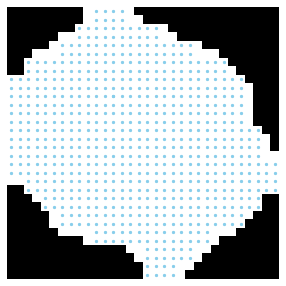

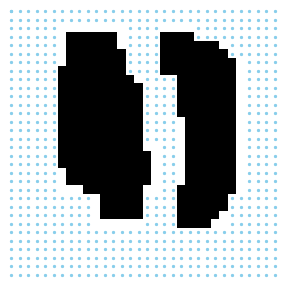

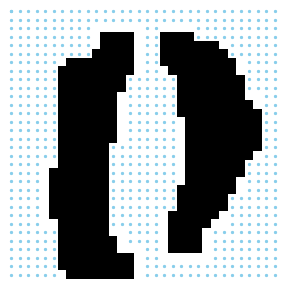

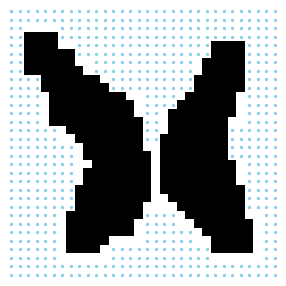

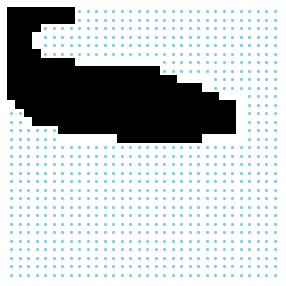

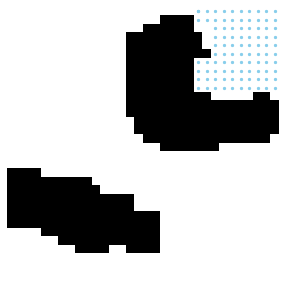

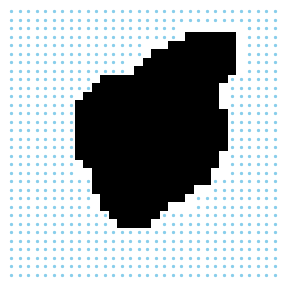

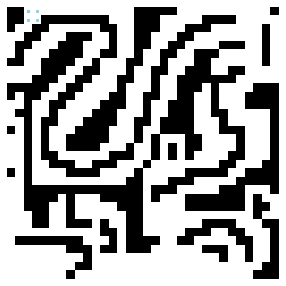

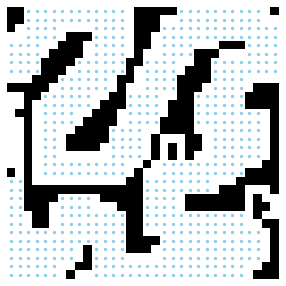

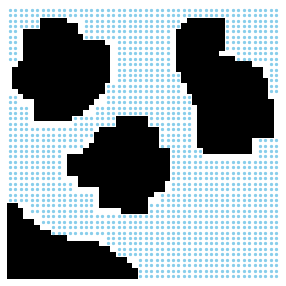

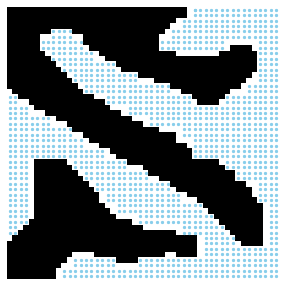

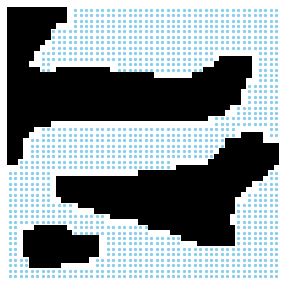

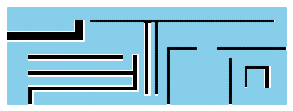

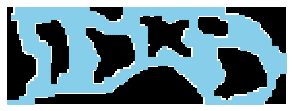

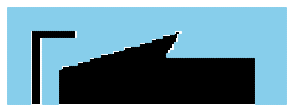

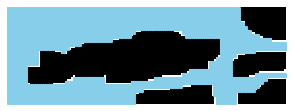

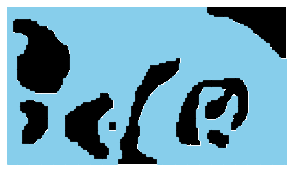

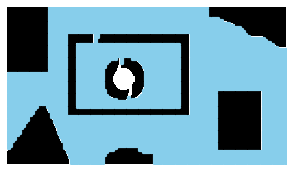

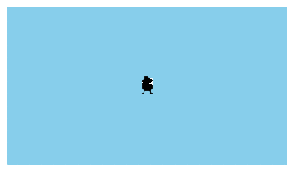

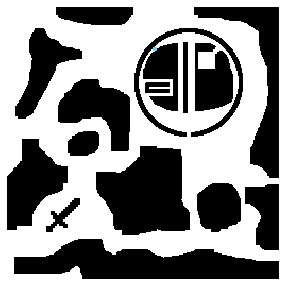

In [22]:
area_maps = get_all_area_maps("./test_maps/")
for area_map in area_maps:
    matrix = stc_preprocess(area_map)
    %time coverage_paths = get_stc_path(matrix)
    print(f"adjacency tests : {adjacency_test(coverage_paths[0])}")
    
    imshow(matrix, cmap="Greys_r")
    imshow_scatter(coverage_paths[0], "skyblue",1, 5 )
    total_len = np.sum([len(cp) for cp in coverage_paths])
    path_count = len(coverage_paths)
    print(f"total_len {total_len} : path_count {path_count}")
    print()